<a href="https://colab.research.google.com/github/AllergictoCrustaceans/ML/blob/main/binary_classification_autism_likelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Likelihood of Autism

Prompt: Given test scores and demographics from autism screening, determine the likelihood of autism of the patient.

Where is data from: https://www.kaggle.com/andrewmvd/autism-screening-on-adults

ML Problem Type: Binary Classification, Imbalanced Data

WARNING: If your API token ever expires, you need to go to: Runtime > Factory Reset Runtime > Run all

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_selection import RFE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

!pip install --upgrade --force-reinstall --no-deps kaggle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=d746f56629655aa550b286d9f9a50977b3a9e4469ef60ca3024ad7e7f1fd0114
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


### 1.) Load via Kaggle API Command

In [ ]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# You can check if everything's okay by running this command.
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              216KB  2021-03-22 08:03:57            737         88  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            609         77  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            597         76  1.0              
imsparsh/musicnet-dataset                               

Since it's just a .csv, there's no need to unzip.

In [ ]:
!kaggle datasets download -d andrewmvd/autism-screening-on-adults --unzip

  0% 0.00/7.38k [00:00<?, ?B/s]
100% 7.38k/7.38k [00:00<00:00, 7.20MB/s]


In [ ]:
# Load csv
ds_raw = pd.read_csv('/content/autism_screening.csv')

###2.) Inspect Data

In [ ]:
ds_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         704 non-null    int64  
 1   A2_Score         704 non-null    int64  
 2   A3_Score         704 non-null    int64  
 3   A4_Score         704 non-null    int64  
 4   A5_Score         704 non-null    int64  
 5   A6_Score         704 non-null    int64  
 6   A7_Score         704 non-null    int64  
 7   A8_Score         704 non-null    int64  
 8   A9_Score         704 non-null    int64  
 9   A10_Score        704 non-null    int64  
 10  age              702 non-null    float64
 11  gender           704 non-null    object 
 12  ethnicity        704 non-null    object 
 13  jundice          704 non-null    object 
 14  austim           704 non-null    object 
 15  contry_of_res    704 non-null    object 
 16  used_app_before  704 non-null    object 
 17  result          

Some things I notice immediately:
- Misspelled 2 columns. Should be "jaundice", "autism". 
- There are 2 data values missing from the 'age' column. 

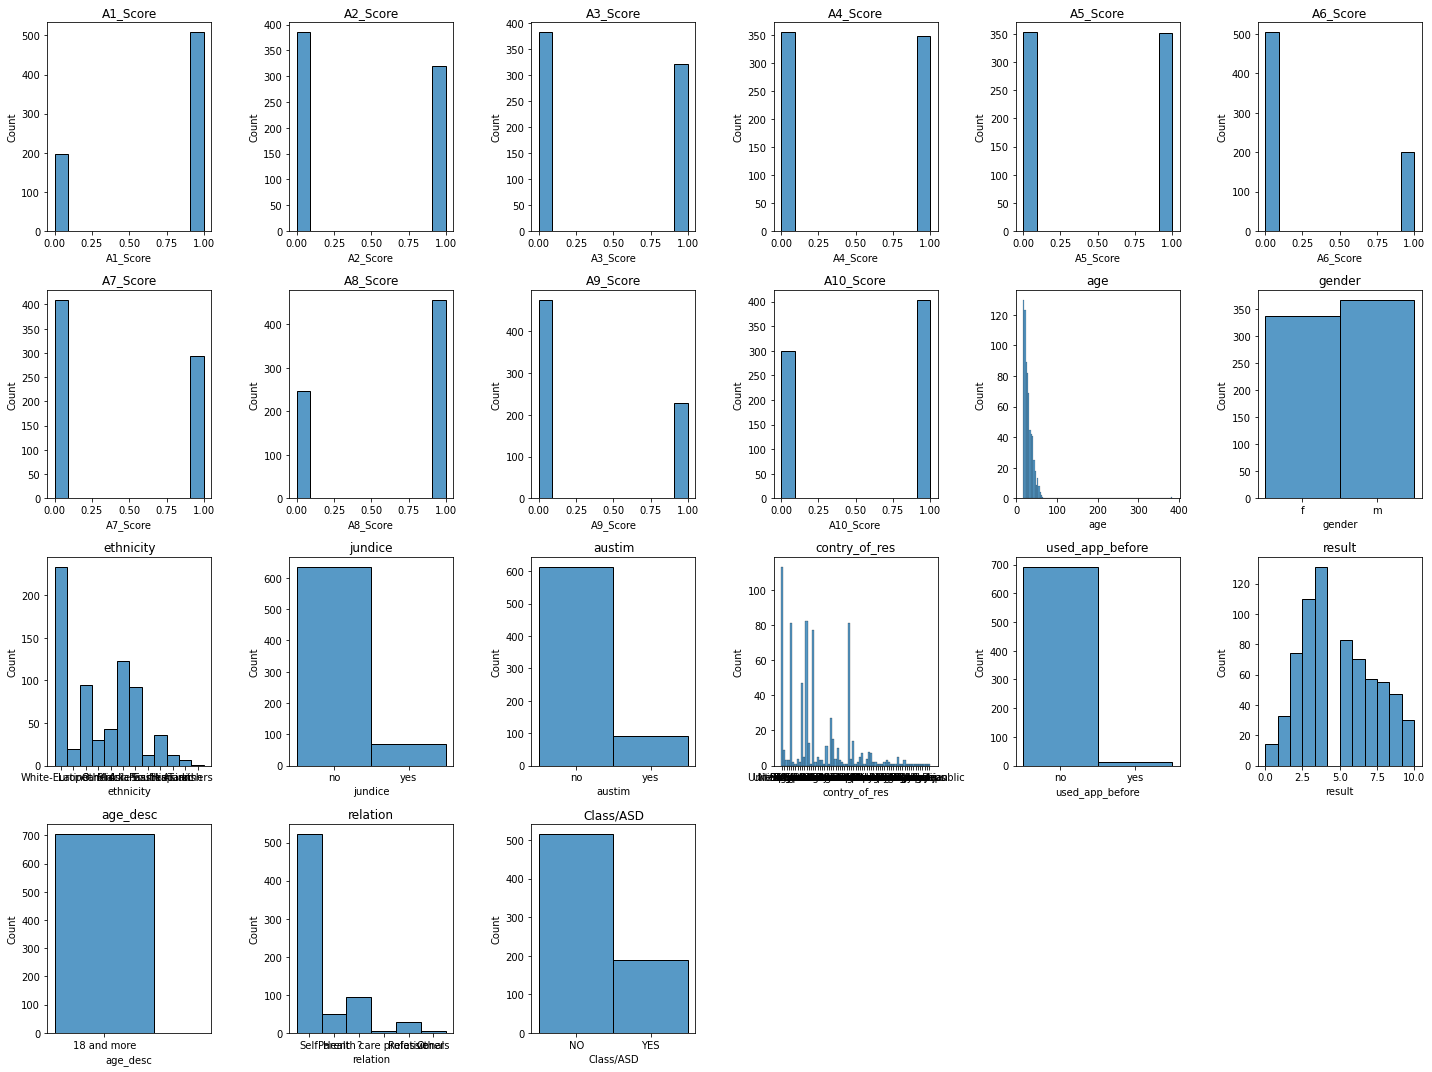

In [ ]:
plt.figure(figsize=(20, 15))

for i, column in enumerate(ds_raw.columns):
    plt.subplot(4, 6, i+1)
    sns.histplot(data=ds_raw[column])
    plt.title(column)
    
plt.tight_layout()
plt.show()

The distributions above indicate that the test scores (e.g. A0, A1, A2, etc.) -- although numerical-- do behave in a categorical sense. For example, a value of 1 is a decisive indication of one thing associated to that A0 score Similarly, a value of 0 is a decisive indication of another thing associated to a particular A0 score.

Some things to notice:
-  Heavy right-skew in age, where most patients that took the survey are young. 
- The 'result' distribution doesn't have anybody scoring a 5 on their autism assessment. Why?
- The 'used_app_before' feature columns may not be helpful in predicting the likelihood of autism in a patient. So, keep in mind to drop this column.

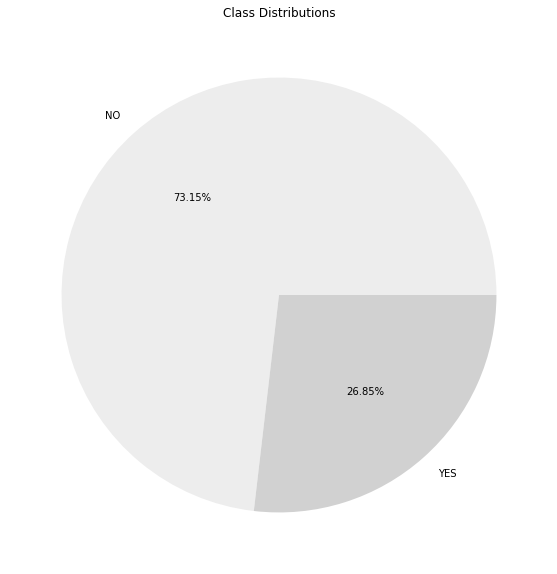

In [ ]:
# Check for data imbalance

plt.figure(figsize=(10, 10))
plt.pie(ds_raw['Class/ASD'].value_counts(),
       autopct='%0.2f%%',
       labels=['NO', 'YES'],
       colors=sns.color_palette('Greys'))

plt.title('Class Distributions')
plt.show()

### 2.) Clean


In [ ]:
# correct misspellings
ds = ds_raw.copy()
ds.columns = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
              'age', 'gender', 'ethnicity', 'jaundice', 'autism', 'country',
              'use_app', 'result', 'age_group', 'relation', 'autism_likelihood']

In [ ]:
# fillna on 'age'
ds['age'] = ds['age'].fillna(ds['age'].mode()[0])

In [ ]:
# Dropping the autism column on features because I don't really know what that column is for.
print('Gender: \n', ds['gender'].unique())
print('Ethnicities: \n', ds['ethnicity'].unique())
print('Jaundice: \n', ds['jaundice'].unique())
print('Country: \n', ds['country'].unique())
print('Used App: \n', ds['use_app'].unique())
print('Age group: \n', ds['age_group'].unique())
print('Relation: \n', ds['relation'].unique())
print('Autism Likelihood: \n', ds['autism_likelihood'].unique())

Gender: 
 ['f' 'm']
Ethnicities: 
 ['White-European' 'Latino' '?' 'Others' 'Black' 'Asian' 'Middle Eastern '
 'Pasifika' 'South Asian' 'Hispanic' 'Turkish' 'others']
Jaundice: 
 ['no' 'yes']
Country: 
 ['United States' 'Brazil' 'Spain' 'Egypt' 'New Zealand' 'Bahamas'
 'Burundi' 'Austria' 'Argentina' 'Jordan' 'Ireland' 'United Arab Emirates'
 'Afghanistan' 'Lebanon' 'United Kingdom' 'South Africa' 'Italy'
 'Pakistan' 'Bangladesh' 'Chile' 'France' 'China' 'Australia' 'Canada'
 'Saudi Arabia' 'Netherlands' 'Romania' 'Sweden' 'Tonga' 'Oman' 'India'
 'Philippines' 'Sri Lanka' 'Sierra Leone' 'Ethiopia' 'Viet Nam' 'Iran'
 'Costa Rica' 'Germany' 'Mexico' 'Russia' 'Armenia' 'Iceland' 'Nicaragua'
 'Hong Kong' 'Japan' 'Ukraine' 'Kazakhstan' 'AmericanSamoa' 'Uruguay'
 'Serbia' 'Portugal' 'Malaysia' 'Ecuador' 'Niger' 'Belgium' 'Bolivia'
 'Aruba' 'Finland' 'Turkey' 'Nepal' 'Indonesia' 'Angola' 'Azerbaijan'
 'Iraq' 'Czech Republic' 'Cyprus']
Used App: 
 ['no' 'yes']
Age group: 
 ['18 and more']
Relat

In [ ]:
# correct country misspellings & bundle ? to 'Others'
ds['ethnicity'] = ds['ethnicity'].replace(['Middle Eastern ', '?', 'Pasifika', 'others'], ['Middle Eastern', 'Others', 'Pacifica', 'Others'])
ds['country'] = ds['country'].replace(['Viet Nam'], ['Vietnam'])
ds['relation'] = ds['relation'].replace(['?'], ['Others'])

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   A1                 704 non-null    int64  
 1   A2                 704 non-null    int64  
 2   A3                 704 non-null    int64  
 3   A4                 704 non-null    int64  
 4   A5                 704 non-null    int64  
 5   A6                 704 non-null    int64  
 6   A7                 704 non-null    int64  
 7   A8                 704 non-null    int64  
 8   A9                 704 non-null    int64  
 9   A10                704 non-null    int64  
 10  age                704 non-null    float64
 11  gender             704 non-null    object 
 12  ethnicity          704 non-null    object 
 13  jaundice           704 non-null    object 
 14  autism             704 non-null    object 
 15  country            704 non-null    object 
 16  use_app            704 non

### 3.) Split

In [ ]:
train_df, test_df = train_test_split(ds, test_size=0.2, stratify=ds['autism_likelihood'])
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['autism_likelihood'])

# still dataframes
y_train = train_df[['autism_likelihood']]
y_val = val_df[['autism_likelihood']]
y_test = test_df[['autism_likelihood']]

x_train = train_df.drop(columns=['autism','autism_likelihood'], axis=1)
x_val = val_df.drop(columns=['autism', 'autism_likelihood'], axis=1)
x_test = test_df.drop(columns=['autism', 'autism_likelihood'], axis=1)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(450, 19)
(141, 19)
(113, 19)
(450, 1)
(141, 1)
(113, 1)


### 4.) Preprocess

In [ ]:
# one hot gender, jaunduce, use_app, age_group, relation
# now a csr matrix
ohe = OneHotEncoder(handle_unknown='ignore')
x_train = ohe.fit_transform(x_train)
x_test = ohe.transform(x_test)
x_val = ohe.transform(x_val)

# label encode
# now a csr matrix
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


# Check datasets' shapes
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(450, 152)
(141, 152)
(113, 152)
(450,)
(141,)
(113,)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### Pearson Correlation

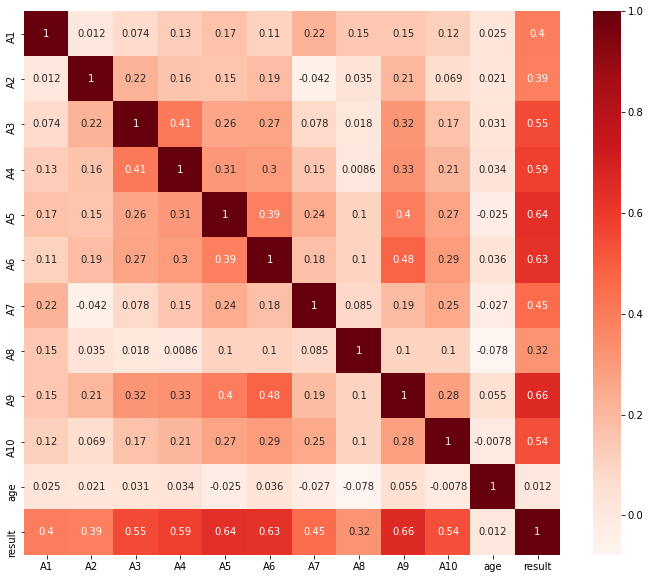

In [ ]:
plt.figure(figsize=(12,10))
cor = ds.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor['result'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

# Pearson correlation only takes in numerical values (floats), no ohe categoricals? 

A3        0.552356
A4        0.586025
A5        0.639706
A6        0.630012
A9        0.661205
A10       0.537205
result    1.000000
Name: result, dtype: float64

In [ ]:
# Analyze correlation between the pearson correlation selected features
print(ds[['A3', 'A4']].corr())
print(ds[['A3', 'A5']].corr())
print(ds[['A3', 'A6']].corr())
print(ds[['A3', 'A9']].corr())
print(ds[['A3', 'A10']].corr())
# there doesn't seem to be any highly correlated variables among the ones selected. So.. keep them all.

          A3        A4
A3  1.000000  0.412722
A4  0.412722  1.000000
          A3        A5
A3  1.000000  0.264927
A5  0.264927  1.000000
          A3        A6
A3  1.000000  0.268846
A6  0.268846  1.000000
          A3        A9
A3  1.000000  0.315113
A9  0.315113  1.000000
           A3       A10
A3   1.000000  0.168454
A10  0.168454  1.000000


### 4.) Build, Train, Evaluate

#### Logistic Regression

In [ ]:
# build logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# build logistic regression model w/ L1 regularization
clf = LogisticRegression(penalty='l1', solver='liblinear',
                         verbose=1, warm_start=True)

# fit model with training data
clf.fit(x_train, y_train)

# predict probability estimates
p_pred = clf.predict_proba(x_test)

# predict class labels given testing data
y_pred = clf.predict(x_test)

# score to return mean accuracy on the given test data and labels
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_perc = 100 * accuracy

# Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Precision V. Recall
class_report = metrics.classification_report(y_test, y_pred)

[LibLinear]

In [ ]:
print('Given test data and labels, this logistic regression model yields a mean accuracy of {}%. '.format(accuracy_perc))

Given test data and labels, this logistic regression model yields a mean accuracy of 100.0%. 


In [ ]:
print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[103   0]
 [  0  38]]


Confusion Matrix Interpretation: 

- True Positive: The model predicted 103 patients to likely NOT have autism, and there are indeed 103 patients that DO NOT autism.

- True Negative: The model predicted 38 patients to likely have autism, and there are indeed 38 patients that have autism.

- False Positive (Type 1 Error): The model predicted 0 patients to likely have autism when they indeed DO NOT have autism.

- False Negative (Type 2 Error): The model predicted 0 patients to not likely have autism when they indeed DO have autism. 

In [ ]:
print('Precision V. Recall: \n ', class_report)

Precision V. Recall: 
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        38

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



Classification Report Interpretation:
- TLDR; support for labels 0 and 1 already indicates data imbalance.

- Recall:
    - For label 0, the model found all 103 cases belonging to this class (100%).
    - For label 1, the model found all 38 cases belonging to this class (100%).

- Precision: (TP/ (TP + FP)). In the above case: (103 / (103 + 0)).
    - For label 0, 100% of those cases were correctly classified.
    - For label 1, 100% of those cases were correctly classified.


- Accuracy: (TP + TN) / (TP + TN + FP + FN). 100% in this case.

- F-score: (2 * recall * precision) / (recall + precision).
    - Harmoni mean between the precision and recall.


### 5.) Thoughts

- With a mean accuracy of 100% on test data, try balancing the data.
- Logistic Regression was fitted using all features (except column 'autism'). Should you use other feature selection techniques (besides L1) to filter out unimpactful features? What feature selection techniques can you use for categorical features?
- What other classification algorithms can you use for this problem? 